In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/ml-1b')
os.chdir('/content/drive/My Drive/Colab Notebooks/ml-1b')
print(os.getcwd())

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/ml-1b


In [2]:
# import process_time
from time import process_time
import pandas as pd
import numpy as np

from cab420_a1b_q1_utils import load_data, vectorise, resize, convert_to_grayscale
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import matplotlib.pyplot as plt

In [3]:
train_X, train_Y, test_X, test_Y = load_data('Q1/q1_train.mat', 'Q1/q1_test.mat')

train_X = convert_to_grayscale(resize(train_X, (28, 28)))
test_X = convert_to_grayscale(resize(test_X, (28, 28)))

train_X, val_X, train_Y, val_Y =train_test_split(train_X, train_Y, test_size=0.2, shuffle= True)
# check shape of data
print(train_X.shape)
print(train_Y.shape)
print(val_X.shape)
print(val_Y.shape)
print(test_X.shape)
print(test_Y.shape)

df_describe = pd.DataFrame(train_Y)
print(df_describe.describe())

df_describe = pd.DataFrame(train_X.flatten())
df_describe.describe()


(800, 28, 28, 1)
(800,)
(200, 28, 28, 1)
(200,)
(10000, 28, 28, 1)
(10000,)
                0
count  800.000000
mean     3.930000
std      2.693821
min      0.000000
25%      2.000000
50%      3.000000
75%      6.000000
max      9.000000


,0
count,627200.000000
mean,0.465520
std,0.227316
min,0.006953
25%,0.284289
50%,0.456829
75%,0.619695
max,1.000000


Explore data

[[  0  50]
 [  1 141]
 [  2 117]
 [  3  94]
 [  4  86]
 [  5  72]
 [  6  59]
 [  7  69]
 [  8  62]
 [  9  50]]
[ 1  2  3  4  5  6  7  8  9 10]
mean: 80.0


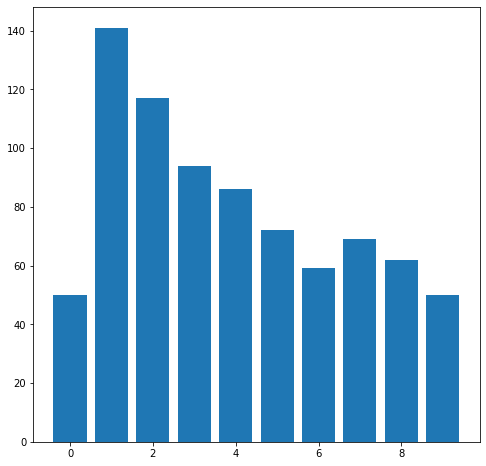

In [4]:
freq = np.array(np.unique(train_Y, return_counts=True)).T
print(freq)
print(freq[:,0]+1)
fig = plt.figure(figsize=[8, 8])
axe = fig.add_subplot(1,1,1)
axe.bar(freq[:,0], freq[:,1])
print(f"mean: {freq[:,1].mean()}")

## SVM

Train a Linear One vs One SVM (with C = 1), on the provided abridged SVHN
training set.

### Vectorise Data

To train an SVM, each sample needs to be a vector rather than an image.

In [5]:
train_vector_X = vectorise(train_X)
test_vector_X = vectorise(test_X)
print(train_vector_X.shape)
print(test_vector_X.shape)

(800, 784)
(10000, 784)


In [6]:
# define model
model_1 = SVC(C=1, kernel="linear")

# get a start time
time_1 = process_time()

# fit model
model_1.fit(train_vector_X, train_Y)

time_2 = process_time()
# make predictions
yhat = model_1.predict(test_vector_X)

time_3 = process_time()
model_1_training_time = time_2 - time_1
model_1_inference_time = time_3 - time_2
print(f"Time to fit the SVM {model_1_training_time} seconds")
print(f"Time to make predictions on test data {model_1_inference_time} seconds")


Time to fit the SVM 0.5772994460000005 seconds
Time to make predictions on test data 2.1417035159999998 seconds


0.2906


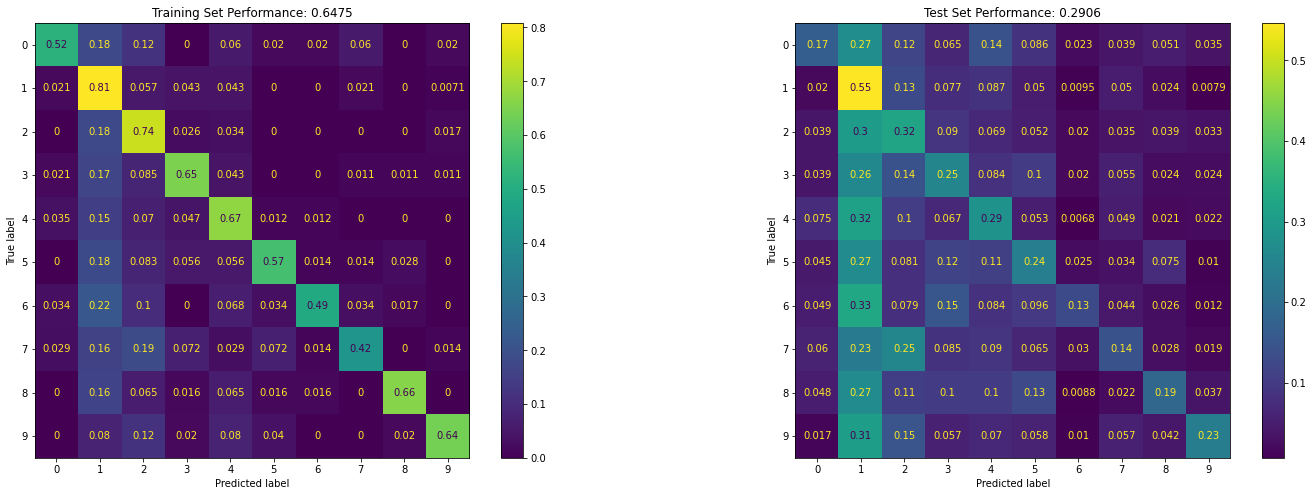

In [7]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Test Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)));
    
    return sum(pred == Y_test)/len(Y_test)

model_1_accuracy = eval_model(model_1, train_vector_X, train_Y, test_vector_X, test_Y)
print(model_1_accuracy)

## DCNNs

Design/select a DCNN architecture and using this one architecture:

### Evaluate the model

In [8]:
def eval_model(model, x_test, y_test):
    test_scores = model.evaluate(x_test, y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    i = tf.cast([], tf.int32)
    indexes = tf.gather_nd(indexes, i)
    
    cm = confusion_matrix(y_test, indexes)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)
    return test_scores[1]
    
def plot_training(history):
    fig = plt.figure(figsize=[20, 6])
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history['loss'], label="Training Loss")
    ax.plot(history.history['val_loss'], label="Validation Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history['accuracy'], label="Training Accuracy")
    ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
    ax.legend();    

### a

Train a model from scratch, using no data augmentation, on the provided abridged
SVHN training set.


In [9]:
batch_size = 128
epochs = 150
architecture = "vgg_3stage_MNIST_bigger.h5"

load the selected architure

Model: "simple_vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 conv2d_35 (Conv2D)          (None, 28, 28, 16)        2320      
                                                                 
 batch_normalization_29 (Bat  (None, 28, 28, 16)       64        
 chNormalization)                                                
                                                                 
 activation_29 (Activation)  (None, 28, 28, 16)        0         
                                                                 
 spatial_dropout2d_17 (Spati  (None, 28, 28, 16)       0         
 alDropout2D)                                           

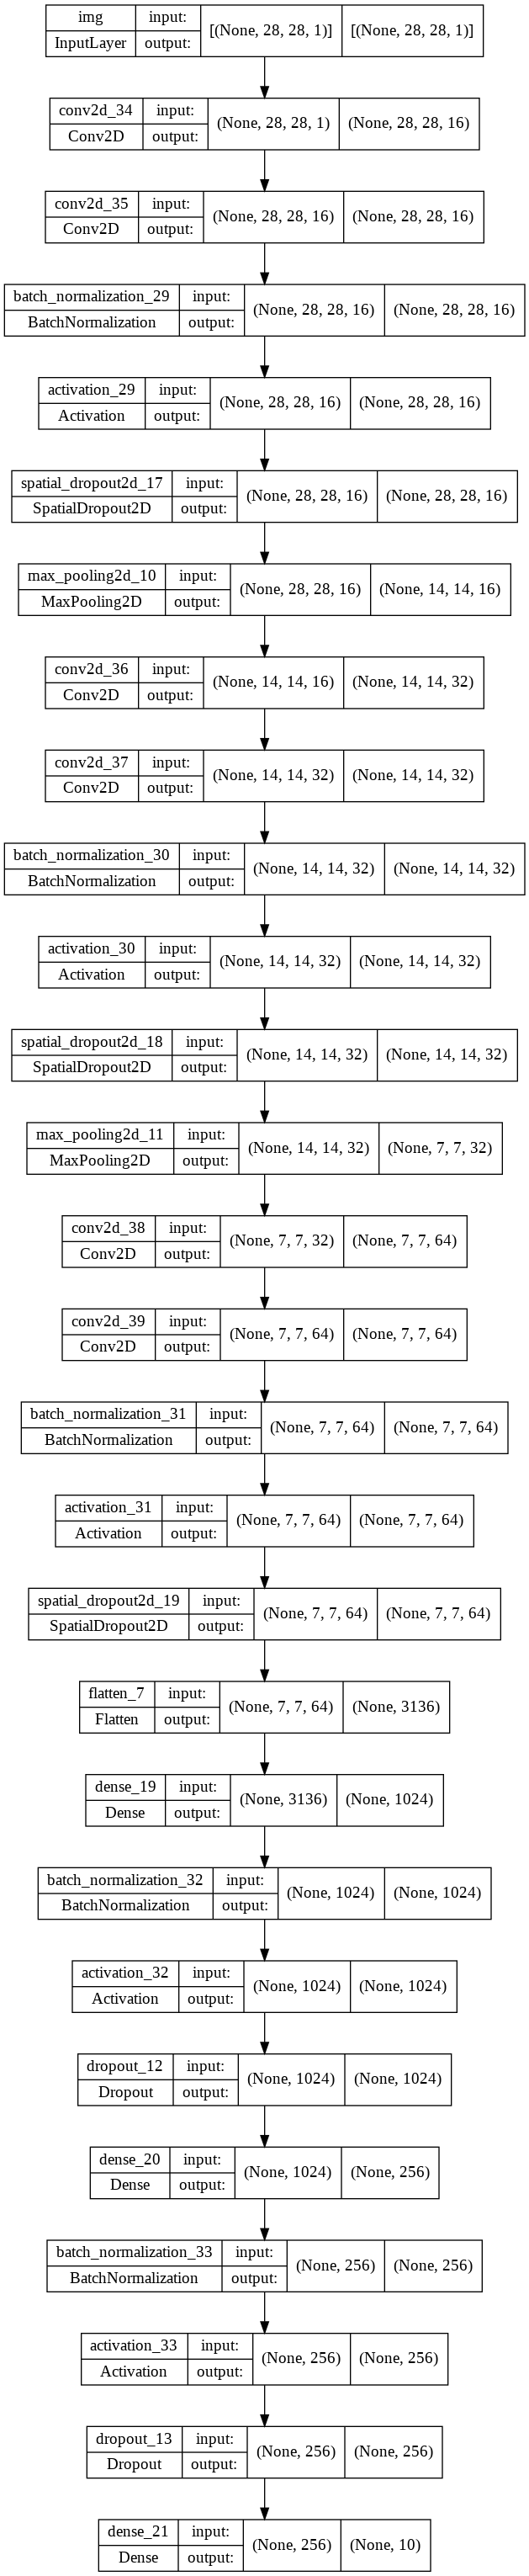

In [10]:
def CreateBaseModel():
  base_model = keras.models.load_model(architecture)
  base_model = tf.keras.Model().from_config(base_model.get_config())

  base_model.summary()
  return base_model
m = CreateBaseModel()
keras.utils.plot_model(m, show_shapes=True)


Model: "simple_vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 conv2d_35 (Conv2D)          (None, 28, 28, 16)        2320      
                                                                 
 batch_normalization_29 (Bat  (None, 28, 28, 16)       64        
 chNormalization)                                                
                                                                 
 activation_29 (Activation)  (None, 28, 28, 16)        0         
                                                                 
 spatial_dropout2d_17 (Spati  (None, 28, 28, 16)       0         
 alDropout2D)                                           

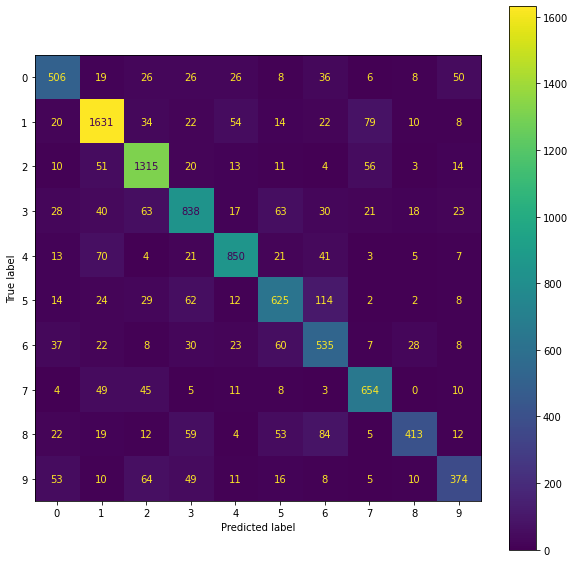

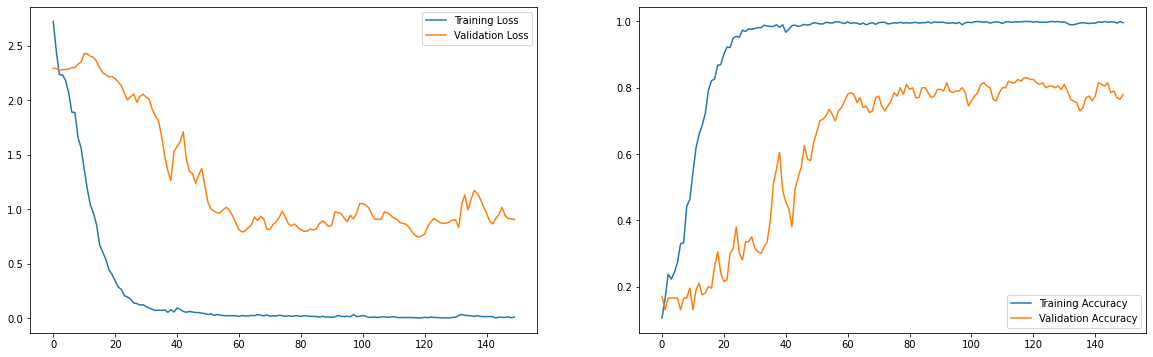

In [11]:
model_2a = CreateBaseModel()
model_2a.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
time_1 = process_time()
history_2a = model_2a.fit(train_X, train_Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(val_X, val_Y))
time_2 = process_time()

model_2a.predict(test_X)
time_3 = process_time()

model_2a_training_time = time_2 - time_1
model_2a_inference_time = time_3 - time_2

print(f"Time to fit the 2a dcnn model {time_2 - time_1} seconds")
print(f"Time to make predictions on test data {time_3 - time_2} seconds")
model_2a_accuracy = eval_model(model_2a, test_X, test_Y)
plot_training(history_2a)


### b

Train a model from scratch, using the data augmentation of your choice, on the
provided abridged SVHN training set.


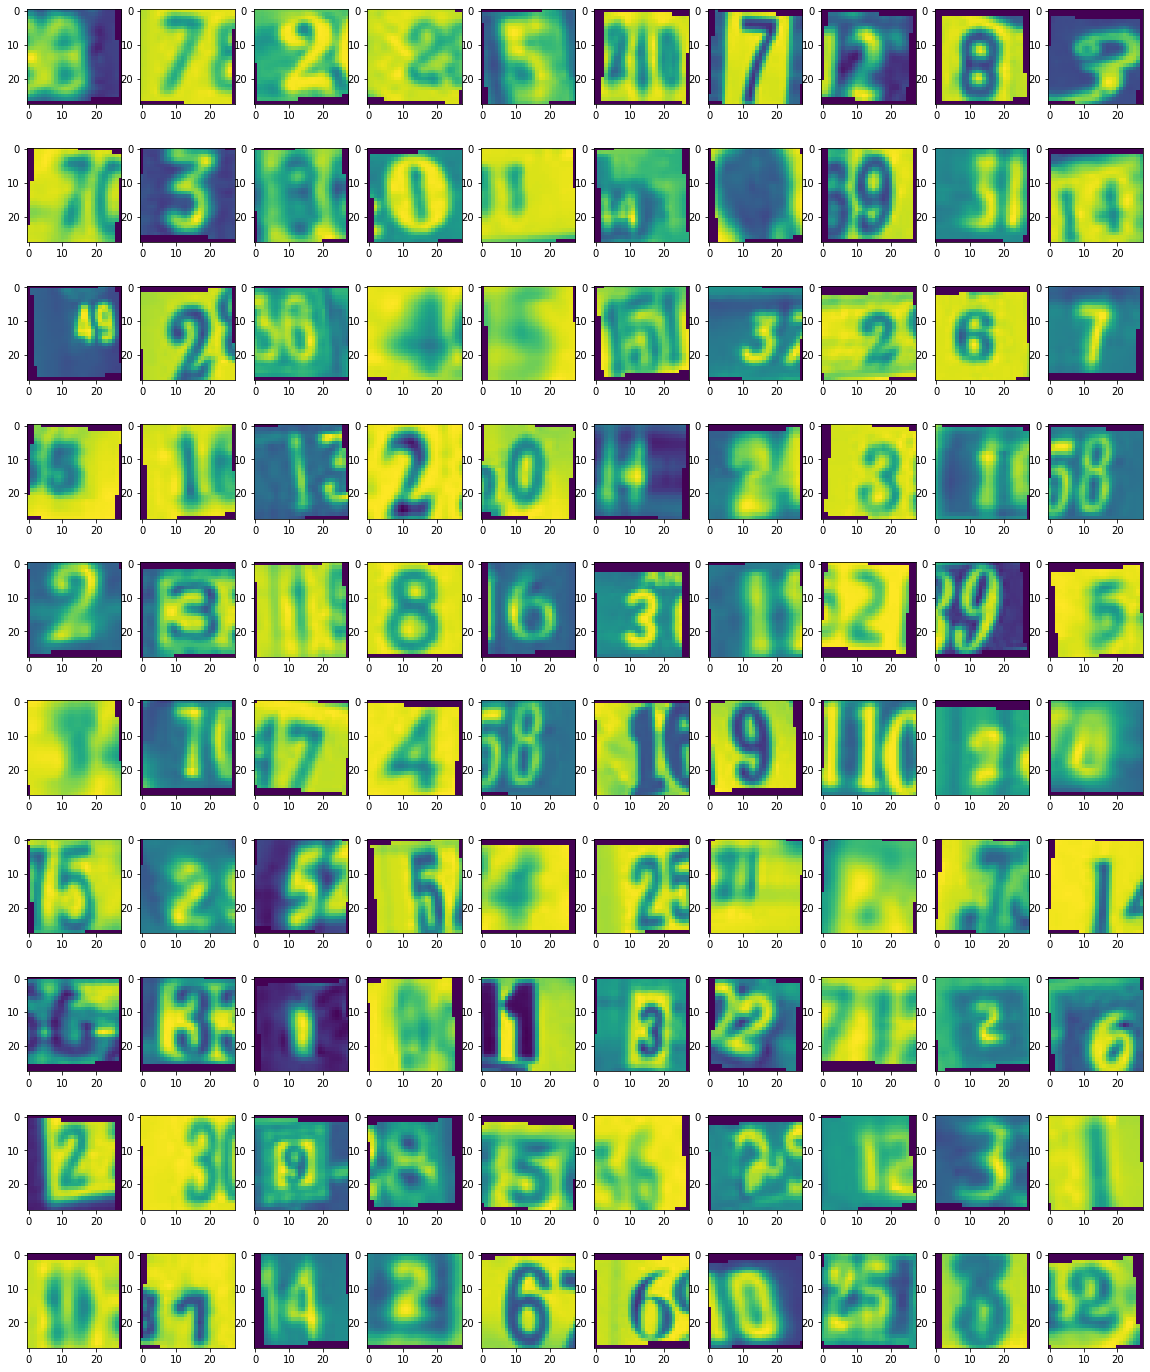

In [12]:
datagen = ImageDataGenerator(
                            # rotate between -5, +5 degrees
                            rotation_range=5,
                            # horiziontal shift by +/- 5% of the image width
                            width_shift_range=0.05,
                            # vertical shift by +/- 5% of the image width
                            height_shift_range=0.05,
                            # range for zooming
                            zoom_range=0.1,
                            # what value to place in new pixels, given the nature of our data
                            # we'll set this to a constant value of 0
                            fill_mode='constant', cval=0)

batch = datagen.flow(train_X, train_Y, batch_size=100)
fig = plt.figure(figsize=[20, 25])
for i,img in enumerate(batch[0][0]):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(img[:,:,0])

Model: "simple_vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 conv2d_35 (Conv2D)          (None, 28, 28, 16)        2320      
                                                                 
 batch_normalization_29 (Bat  (None, 28, 28, 16)       64        
 chNormalization)                                                
                                                                 
 activation_29 (Activation)  (None, 28, 28, 16)        0         
                                                                 
 spatial_dropout2d_17 (Spati  (None, 28, 28, 16)       0         
 alDropout2D)                                           

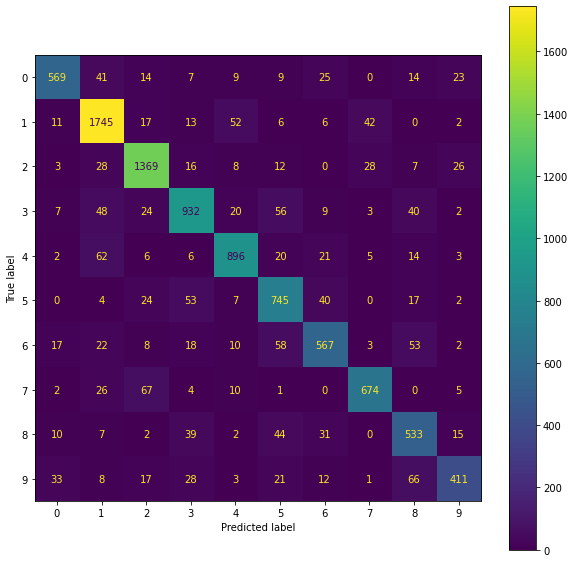

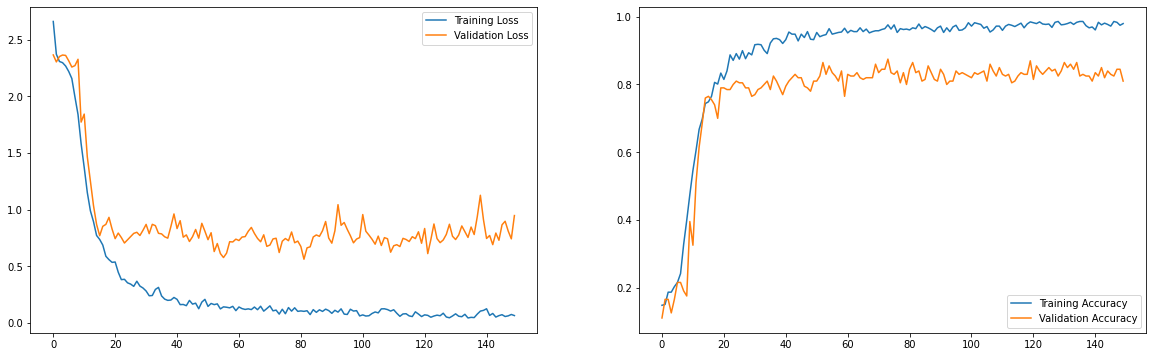

In [13]:
model_2b = CreateBaseModel()
model_2b.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
time_1 = process_time()
history_2b = model_2b.fit( datagen.flow(train_X, train_Y, batch_size=16),
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(val_X, val_Y))
time_2 = process_time()

model_2b.predict(test_X)
time_3 = process_time()

model_2b_training_time = time_2 - time_1
model_2b_inference_time = time_3 - time_2

print(f"Time to fit the 2b dcnn model {time_2 - time_1} seconds")
print(f"Time to make predictions on test data {time_3 - time_2} seconds")

model_2b_accuracy = eval_model(model_2b, test_X, test_Y)
plot_training(history_2b)

### c
Fine tune an existing model, trained on another dataset used in CAB420 (such
as MNIST, KMINST or CIFAR), on the provided abridged SVHN training set.

In [14]:
model_2c = keras.models.load_model(architecture)


model_2c.summary()

# Freeze the layers except the last n layers
for layer in model_2c.layers[:-8]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in model_2c.layers:
    print(layer, layer.trainable)

Model: "simple_vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_34 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 conv2d_35 (Conv2D)          (None, 28, 28, 16)        2320      
                                                                 
 batch_normalization_29 (Bat  (None, 28, 28, 16)       64        
 chNormalization)                                                
                                                                 
 activation_29 (Activation)  (None, 28, 28, 16)        0         
                                                                 
 spatial_dropout2d_17 (Spati  (None, 28, 28, 16)       0         
 alDropout2D)                                           

Epoch 1/150
7/7 [==============================] - 2s 66ms/step - loss: 7.2010 - accuracy: 0.2738 - val_loss: 5.5565 - val_accuracy: 0.2650
Epoch 2/150
7/7 [==============================] - 0s 18ms/step - loss: 5.9021 - accuracy: 0.2887 - val_loss: 4.9677 - val_accuracy: 0.2900
Epoch 3/150
7/7 [==============================] - 0s 18ms/step - loss: 5.0343 - accuracy: 0.3025 - val_loss: 4.5152 - val_accuracy: 0.3000
Epoch 4/150
7/7 [==============================] - 0s 17ms/step - loss: 4.4830 - accuracy: 0.3088 - val_loss: 4.1545 - val_accuracy: 0.3150
Epoch 5/150
7/7 [==============================] - 0s 19ms/step - loss: 4.0845 - accuracy: 0.3650 - val_loss: 3.5365 - val_accuracy: 0.3150
Epoch 6/150
7/7 [==============================] - 0s 18ms/step - loss: 3.5918 - accuracy: 0.3375 - val_loss: 2.9547 - val_accuracy: 0.3450
Epoch 7/150
7/7 [==============================] - 0s 17ms/step - loss: 3.0147 - accuracy: 0.4062 - val_loss: 2.5825 - val_accuracy: 0.3700
Epoch 8/150
7/7 [===

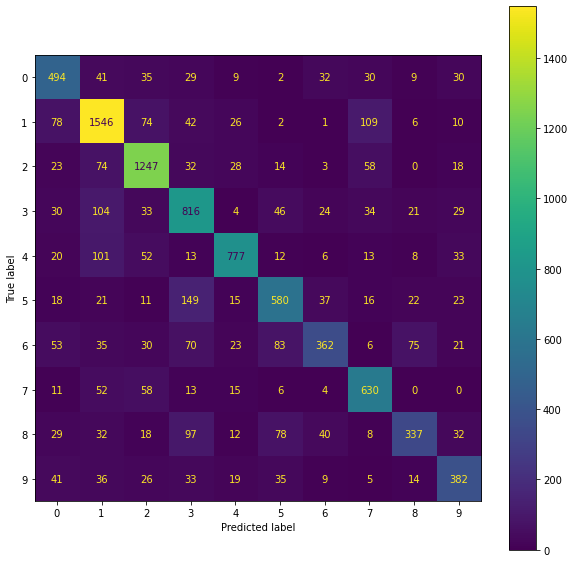

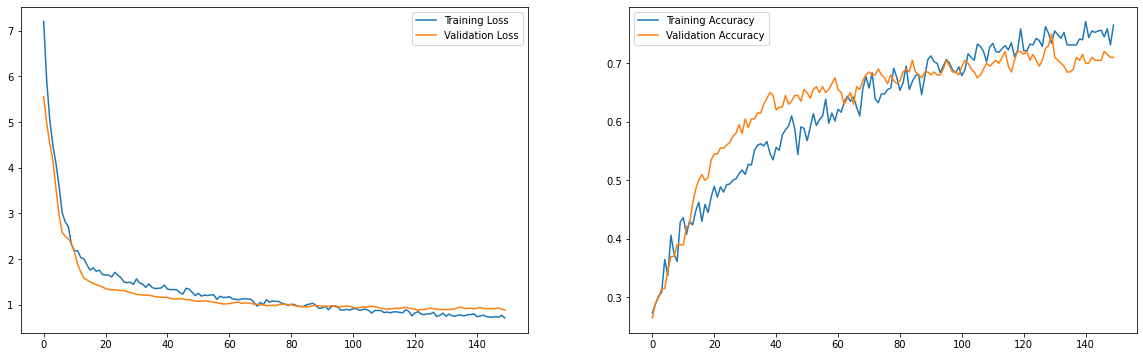

In [15]:
model_2c.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
time_1 = process_time()
history_2c = model_2c.fit(train_X, train_Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(val_X, val_Y))
time_2 = process_time()
model_2c.predict(test_X)
time_3 = process_time()

model_2c_training_time = time_2 - time_1
model_2c_inference_time = time_3 - time_2

print(f"Time to fit the 2c dcnn model {time_2 - time_1} seconds")
print(f"Time to make predictions on test data {time_3 - time_2} seconds")

model_2c_accuracy = eval_model(model_2c, test_X, test_Y)
plot_training(history_2c)

## Comparation

Text(0.5, 1.0, 'Inference Time as Model Changes')

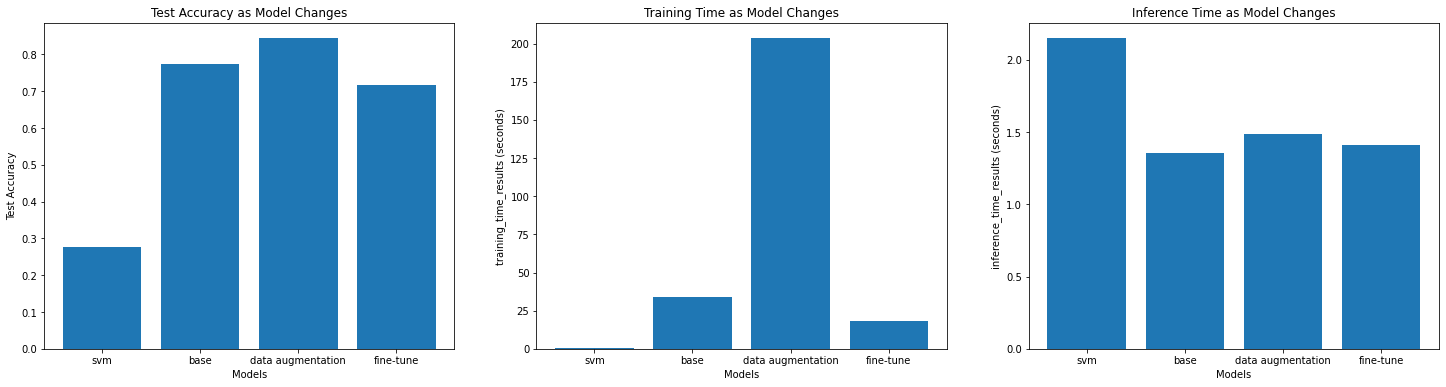

In [16]:
accuracy_results = {
    "svm":model_1_accuracy,
    "base":model_2a_accuracy,
    "data augmentation":model_2b_accuracy,
    "fine-tune":model_2c_accuracy
}
training_time_results = {
    "svm":model_1_training_time,
    "base":model_2a_training_time,
    "data augmentation":model_2b_training_time,
    "fine-tune":model_2c_training_time
}
inference_time_results = {
    "svm":model_1_inference_time,
    "base":model_2a_inference_time,
    "data augmentation":model_2b_inference_time,
    "fine-tune":model_2c_inference_time
}

fig = plt.figure(figsize =(25, 6))
ax = fig.add_subplot(1,3,1)
ax.bar(list(accuracy_results.keys()), list(accuracy_results.values()))
ax.set_xlabel("Models")
ax.set_ylabel("Test Accuracy")
ax.set_title("Test Accuracy as Model Changes")

ax = fig.add_subplot(1,3,2)
ax.bar(list(training_time_results.keys()), list(training_time_results.values()))
ax.set_xlabel("Models")
ax.set_ylabel("training_time_results (seconds)")
ax.set_title("Training Time as Model Changes")


ax = fig.add_subplot(1,3,3)
ax.bar(list(inference_time_results.keys()), list(inference_time_results.values()))
ax.set_xlabel("Models")
ax.set_ylabel("inference_time_results (seconds)")
ax.set_title("Inference Time as Model Changes")
